<a href="https://colab.research.google.com/github/MahirMahbub/Financial-Sentiment-Ananlysis-and-Topic-Modeling/blob/main/FinBert_Sentiment_%26_Topic_Modeling_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Generation

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 18.1 MB/s 
     |████████████████████████████████| 895 kB 29.5 MB/s 
     |████████████████████████████████| 636 kB 26.5 MB/s 
     |████████████████████████████████| 3.3 MB 73.3 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline



In [ ]:
def model_loader(load_model: str = 'yiyanghkust/finbert-tone', task_type:str = "sentiment-analysis"):
  finbert = BertForSequenceClassification.from_pretrained(load_model,num_labels=3)
  tokenizer = BertTokenizer.from_pretrained(load_model)
  nlp = pipeline(task_type, model=finbert, tokenizer=tokenizer)
  return nlp

In [ ]:
def predictor(pipe_line, sentences):
  results = pipe_line(sentences)
  label_tag = {"LABEL_0": "neutral", "LABEL_1": "positive", "LABEL_2": "negative"}
  results = [{'label': label_tag[res["label"]], 'score':res["score"]}for res in results]
  return results

# TEST FinBert MODEL

In [ ]:

import json
sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat",
             "Pre-tax loss totaled euro 0.3 million, compared to a loss of euro 2.2 million in the first quarter of 2005",
             "This implementation is very important to the operator, since it is about to launch its Fixed to Mobile convergence service in Brazil",
             "The situation of coated magazine printing paper will continue to be weak"]
pipe_line = model_loader()
results = predictor(pipe_line, sentences)
print(json.dumps(results, indent=4))

[
    {
        "label": "negative",
        "score": 0.9966173768043518
    },
    {
        "label": "positive",
        "score": 1.0
    },
    {
        "label": "negative",
        "score": 0.9999710321426392
    },
    {
        "label": "neutral",
        "score": 0.9889442920684814
    },
    {
        "label": "neutral",
        "score": 0.7256450653076172
    },
    {
        "label": "neutral",
        "score": 0.9984122514724731
    },
    {
        "label": "negative",
        "score": 0.9999972581863403
    }
]


# Topic Identification

In [1]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 9.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
! pip install pyLDAvis==2.0.0

     |████████████████████████████████| 2.2 MB 12.7 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.0.0-py2.py3-none-any.whl size=97472 sha256=c987fd273b1d8c0a8e4c1bcdbd96ef161cc7158f41b2a89841bd70c596463696
  Stored in directory: /root/.cache/pip/wheels/90/6a/ce/318436e940fd8e6ec16869a7d5fe77827c927557a3cf4f647e
Successfully built pyLDAvis


In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/reg_follow.csv', header=0)
print(df.head())

                                               title  ...                                        description
0             Transfer Pricing Brief: September 2021  ...  China APAs-Unilateral: On 26 July 2021: the St...
1  Germany publishes Guidance on MAP and arbitrat...  ...  On 27 August 2021: the Federal Ministry of Fin...
2                   Denmark presents Budget for 2022  ...  On 30 August 2021: the Minister of Finance pre...
3  Qatar: GTA extends deadline for filing tax ret...  ...  On 30 August 2021: the General Tax Authority (...
4  US: IRS publishes joint statement with Germany...  ...  The Internal Revenue Service (IRS) published a...

[5 rows x 5 columns]


In [8]:
data = df.title.values.tolist()
data

['Transfer Pricing Brief: September 2021',
 'Germany publishes Guidance on MAP and arbitration procedures',
 'Denmark presents Budget for 2022',
 'Qatar: GTA extends deadline for filing tax returns',
 'US: IRS publishes joint statement with Germany on the exchange of CbC reports',
 'US: IRS publishes joint statement with France on the exchange of CbC reports',
 'EU: Proposed carbon border tax criticised by BRICS countries',
 'Finland: MOF launches public consultation on transfer pricing adjustment',
 'Russia: MOF clarifies the deductibility of R&D expenses for CIT purposes',
 'German: Federal Constitutional Court voids 6% interest rate on back taxes',
 'UK: Survey Indicates Businesses are Unprepared for Plastic Packaging Tax',
 'UK: Professional Bodies Request a Delay to Introduction of Tax Changes',
 'Thailand extends CIT return filing deadline',
 'India: CBDT notifies a formula to adjust MAT relief for secondary adjustment and APA',
 'UK: Statistics on Creative Industries Tax Relief'

In [9]:
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])

['Transfer Pricing Brief: September 2021']


<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<ipython-input-9-6b9fa7375985>:1: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-9-6b9fa7375985>:4: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', '

In [42]:
pprint(data[:10])

['Transfer Pricing Brief: September 2021',
 'Germany publishes Guidance on MAP and arbitration procedures',
 'Denmark presents Budget for 2022',
 'Qatar: GTA extends deadline for filing tax returns',
 'US: IRS publishes joint statement with Germany on the exchange of CbC '
 'reports',
 'US: IRS publishes joint statement with France on the exchange of CbC reports',
 'EU: Proposed carbon border tax criticised by BRICS countries',
 'Finland: MOF launches public consultation on transfer pricing adjustment',
 'Russia: MOF clarifies the deductibility of R&D expenses for CIT purposes',
 'German: Federal Constitutional Court voids 6% interest rate on back taxes']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['transfer', 'pricing', 'brief', 'september']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['transfer', 'pricing', 'brief', 'september']


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

[['transfer', 'pricing', 'brief']]


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

In [14]:
print(data_lemmatized[:1])

[['transfer', 'pricing', 'brief']]


In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [16]:
id2word[0]

'brief'

# USING LDA

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [17]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

NameError: ignored

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

# Using MALLET

In [18]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-09-07 19:42:04--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  10.3MB/s    in 1.5s    

2021-09-07 19:42:06 (10.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [19]:
! unzip /content/mallet-2.0.8.zip

Archive:  /content/mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.cla

In [20]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [21]:
pprint(ldamallet.show_topics(formatted=False))

[(8,
  [('publish', 0.4423076923076923),
   ('country', 0.08653846153846154),
   ('finance', 0.04807692307692308),
   ('government', 0.038461538461538464),
   ('economic', 0.028846153846153848),
   ('hybrid', 0.028846153846153848),
   ('consultation', 0.028846153846153848),
   ('request', 0.028846153846153848),
   ('adjustment', 0.019230769230769232),
   ('list', 0.019230769230769232)]),
 (18,
  [('rule', 0.26732673267326734),
   ('regard', 0.1485148514851485),
   ('dispute', 0.0594059405940594),
   ('decision', 0.04950495049504951),
   ('apa', 0.04950495049504951),
   ('introduce', 0.04950495049504951),
   ('group', 0.039603960396039604),
   ('prosecution', 0.0297029702970297),
   ('luxembourg', 0.009900990099009901),
   ('thin', 0.009900990099009901)]),
 (4,
  [('public', 0.10869565217391304),
   ('year', 0.08695652173913043),
   ('comment', 0.06521739130434782),
   ('implement', 0.05434782608695652),
   ('mutual', 0.05434782608695652),
   ('cit', 0.043478260869565216),
   ('launch',

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.7422509130930465


# Find Optimal Topic Number

In [22]:
def compute_coherence_values_mallet(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coh = coherencemodel.get_coherence()
        print(coh)
        coherence_values.append(coh)

    return model_list, coherence_values

# Using Mallet

In [23]:
model_list_mallet, coherence_values_mallet = compute_coherence_values_mallet(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

# Using LDA

In [ ]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore')
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=6)


# Using Mallet

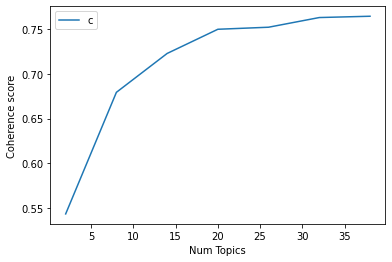

In [24]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_mallet)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
for m, cv in zip(x, coherence_values_mallet):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5431
Num Topics = 8  has Coherence Value of 0.6794
Num Topics = 14  has Coherence Value of 0.723
Num Topics = 20  has Coherence Value of 0.7501
Num Topics = 26  has Coherence Value of 0.7524
Num Topics = 32  has Coherence Value of 0.7632
Num Topics = 38  has Coherence Value of 0.7647


# Using LDA

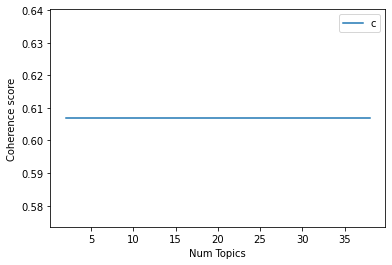

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Using Mallet

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5164
Num Topics = 8  has Coherence Value of 0.703
Num Topics = 14  has Coherence Value of 0.7182
Num Topics = 20  has Coherence Value of 0.7494
Num Topics = 26  has Coherence Value of 0.7688
Num Topics = 32  has Coherence Value of 0.7546
Num Topics = 38  has Coherence Value of 0.752


# Optimal Topic (LDA)

In [ ]:
optimal_topic = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Optimal Topic (Mallet)

In [27]:
optimal_topic = 20
lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_topic, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[(5,
  [('transfer', 0.25892857142857145),
   ('pricing', 0.24107142857142858),
   ('release', 0.08035714285714286),
   ('decree', 0.044642857142857144),
   ('documentation', 0.03571428571428571),
   ('present', 0.03571428571428571),
   ('obligation', 0.026785714285714284),
   ('disclosure', 0.026785714285714284),
   ('instrument', 0.026785714285714284),
   ('international', 0.017857142857142856)]),
 (11,
  [('measure', 0.13043478260869565),
   ('corporate', 0.11956521739130435),
   ('make', 0.08695652173913043),
   ('extend', 0.06521739130434782),
   ('budget', 0.06521739130434782),
   ('change', 0.06521739130434782),
   ('transparency', 0.043478260869565216),
   ('regulation', 0.03260869565217391),
   ('foreign', 0.021739130434782608),
   ('suspension', 0.021739130434782608)]),
 (8,
  [('publish', 0.4423076923076923),
   ('country', 0.08653846153846154),
   ('finance', 0.04807692307692308),
   ('government', 0.038461538461538464),
   ('economic', 0.028846153846153848),
   ('hybrid', 

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, default="mallet"):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        if default == "mallet":
          row = sorted(row, key=lambda x: (x[1]), reverse=True)
        else: 
          row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant top 3 topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Using Topic (LDA)

In [ ]:
# Top 1
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, default="lda")

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic)


     Document_No  ...                                               Text
0              0  ...             Transfer Pricing Brief: September 2021
1              1  ...  Germany publishes Guidance on MAP and arbitrat...
2              2  ...                   Denmark presents Budget for 2022
3              3  ...  Qatar: GTA extends deadline for filing tax ret...
4              4  ...  US: IRS publishes joint statement with Germany...
..           ...  ...                                                ...
487          487  ...  OECD: Public Consultation on Tax Challenges of...
488          488  ...                         Sri Lanka: Budget for 2021
489          489  ...            Italy extends DST deadlines for FY 2020
490          490  ...  Thailand: Tax authority prolongs e-Filing dead...
491          491  ...  France: Supreme Administrative Court makes a d...

[492 rows x 5 columns]


In [ ]:
print(df_dominant_topic.iloc[:, 1:4])
print(len(corpus))

     Dominant_Topic  ...                                           Keywords
0               2.0  ...  decision, make, publish, dispute, tp, report, ...
1               2.0  ...  decision, make, publish, dispute, tp, report, ...
2               3.0  ...  issue, year, guidance, development, relief, pa...
3               0.0  ...  deadline, extend, return, extension, file, pro...
4               2.0  ...  decision, make, publish, dispute, tp, report, ...
..              ...  ...                                                ...
487             3.0  ...  issue, year, guidance, development, relief, pa...
488             0.0  ...  deadline, extend, return, extension, file, pro...
489             0.0  ...  deadline, extend, return, extension, file, pro...
490             0.0  ...  deadline, extend, return, extension, file, pro...
491             2.0  ...  decision, make, publish, dispute, tp, report, ...

[492 rows x 3 columns]
492


In [ ]:
# !pip install pyldavis==2.0.0 numexpr



     |████████████████████████████████| 2.2 MB 27.9 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.0.0-py2.py3-none-any.whl size=97472 sha256=c2aa9a08e70f45e29dc99d39acd6dcee460d00d045137b09abb9b6358835fa02
  Stored in directory: /root/.cache/pip/wheels/90/6a/ce/318436e940fd8e6ec16869a7d5fe77827c927557a3cf4f647e
Successfully built pyldavis
  Attempting uninstall: pyldavis
    Found existing installation: pyLDAvis 3.3.1
    Uninstalling pyLDAvis-3.3.1:
      Successfully uninstalled pyLDAvis-3.3.1


In [32]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

AttributeError: ignored

# Using Topic (Mallet)

In [29]:
# Top 1
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


     Document_No  ...                                               Text
0              0  ...             Transfer Pricing Brief: September 2021
1              1  ...  Germany publishes Guidance on MAP and arbitrat...
2              2  ...                   Denmark presents Budget for 2022
3              3  ...  Qatar: GTA extends deadline for filing tax ret...
4              4  ...  US: IRS publishes joint statement with Germany...
..           ...  ...                                                ...
487          487  ...  OECD: Public Consultation on Tax Challenges of...
488          488  ...                         Sri Lanka: Budget for 2021
489          489  ...            Italy extends DST deadlines for FY 2020
490          490  ...  Thailand: Tax authority prolongs e-Filing dead...
491          491  ...  France: Supreme Administrative Court makes a d...

[492 rows x 5 columns]


In [43]:
pprint(data[:5])

['Transfer Pricing Brief: September 2021',
 'Germany publishes Guidance on MAP and arbitration procedures',
 'Denmark presents Budget for 2022',
 'Qatar: GTA extends deadline for filing tax returns',
 'US: IRS publishes joint statement with Germany on the exchange of CbC '
 'reports']


In [30]:
print(df_dominant_topic.iloc[:, 1:4])
print(len(corpus))

     Dominant_Topic  ...                                           Keywords
0              10.0  ...  transfer, pricing, introduce, dispute, adjustm...
1               0.0  ...  publish, loss, procedure, budget, enact, penal...
2               0.0  ...  publish, loss, procedure, budget, enact, penal...
3               3.0  ...  extend, deadline, file, filing, provision, sub...
4              11.0  ...  report, requirement, finance, guideline, decre...
..              ...  ...                                                ...
487            12.0  ...  payment, deadline, extend, year, economy, comp...
488             0.0  ...  publish, loss, procedure, budget, enact, penal...
489             3.0  ...  extend, deadline, file, filing, provision, sub...
490             3.0  ...  extend, deadline, file, filing, provision, sub...
491             9.0  ...  regard, bep, bill, decision, transparency, met...

[492 rows x 3 columns]
492


In [34]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import gensim    
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, id2word)
vis

AttributeError: ignored

In [36]:
lda_model.save('/content/drive/MyDrive/Model/lda_train_mallet.model')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


# Topic Classifier

In [39]:

train_vecs = []
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)
for i in range(len(corpus)):
    top_topics = model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(optimal_topic)]
    # topic_vec.extend([len(rev_train.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

In [41]:
pprint(train_vecs)
# df_dominant_topic

Streaming output truncated to the last 5000 lines.
 [0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.0660377358490566,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.0660377358490566,
  0.04716981132075472,
  0.04716981132075472,
  0.0660377358490566,
  0.04716981132075472],
 [0.08335918665129717,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.048716285046816035,
  0.04716981132075472,
  0.0660377358490566,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472,
  0.04716981132075472],
 [0.04961671652449489,
  0.066

In [54]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

In [91]:
X = np.array(train_vecs)
y = np.array(df_dominant_topic.Dominant_Topic)

kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1, cv_mlp_f1, cv_knn_f1  = [], [], [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # Scale Data
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_val_scale = scaler.transform(X_val)

    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)
    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='micro'))

    # MLP Classifier
    lr = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(400,200), 
                    random_state=1, max_iter=2000, solver = "adam", early_stopping=True, n_iter_no_change = 1000).fit(X_train_scale, y_train)
    y_pred = lr.predict(X_val_scale)
    cv_mlp_f1.append(f1_score(y_val, y_pred, average='micro'))
    
    # Logistic Regression SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='micro'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='micro'))

    # KNN Classifier
    
    from sklearn.neighbors import KNeighborsClassifier
    lr = KNeighborsClassifier(n_neighbors=8).fit(X_train_scale, y_train)
    y_pred = lr.predict(X_val_scale)
    cv_knn_f1.append(f1_score(y_val, y_pred, average='micro'))

print(f'MLP Val f1: {np.mean(cv_mlp_f1):.3f} +- {np.std(cv_mlp_f1):.3f}')
print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')
print(f'KNN Val f1: {np.mean(cv_knn_f1):.3f} +- {np.std(cv_knn_f1):.3f}')

MLP Val f1: 0.756 +- 0.033
Logistic Regression Val f1: 0.728 +- 0.025
Logisitic Regression SGD Val f1: 0.626 +- 0.043
SVM Huber Val f1: 0.136 +- 0.096
KNN Val f1: 0.669 +- 0.037


In [122]:
import pickle


with open('/content/drive/MyDrive/Dataset/train_dataset.pickle', 'wb') as output:
    pickle.dump(X, output)
with open('/content/drive/MyDrive/Dataset/train_label_dataset.pickle', 'wb') as output:
    pickle.dump(y, output)

with open('/content/drive/MyDrive/Dataset/train_dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)
    print(dataset)

[[0.04807692 0.04807692 0.04807692 ... 0.04807692 0.04807692 0.04807692]
 [0.08268845 0.0462963  0.0462963  ... 0.04694118 0.0462963  0.06184749]
 [0.06730769 0.04807692 0.04807692 ... 0.04807692 0.04807692 0.04807692]
 ...
 [0.04901961 0.04901961 0.04901961 ... 0.04901961 0.04901961 0.05150096]
 [0.04545455 0.04701651 0.04545455 ... 0.04545455 0.04545455 0.05184854]
 [0.04545455 0.04545455 0.06363636 ... 0.04545455 0.04545455 0.04545455]]


k = 7 KNN Val f1: 0.655 +- 0.024


k = 8 KNN Val f1: 0.669 +- 0.037


k = 9 KNN Val f1: 0.650 +- 0.046


k = 10 KNN Val f1: 0.652 +- 0.053

In [2]:
! pip install lazypredict

In [22]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle



In [10]:
try:
  X = np.array(train_vecs)
  y = np.array(df_dominant_topic.Dominant_Topic)
except Exception as e:
  with open('/content/drive/MyDrive/Dataset/train_dataset.pickle', 'rb') as data:
    X = pickle.load(data)
  with open('/content/drive/MyDrive/Dataset/train_label_dataset.pickle', 'rb') as data:
    y = pickle.load(data)
print(X,y)
  

[[0.04807692 0.04807692 0.04807692 ... 0.04807692 0.04807692 0.04807692]
 [0.08268845 0.0462963  0.0462963  ... 0.04694118 0.0462963  0.06184749]
 [0.06730769 0.04807692 0.04807692 ... 0.04807692 0.04807692 0.04807692]
 ...
 [0.04901961 0.04901961 0.04901961 ... 0.04901961 0.04901961 0.05150096]
 [0.04545455 0.04701651 0.04545455 ... 0.04545455 0.04545455 0.05184854]
 [0.04545455 0.04545455 0.06363636 ... 0.04545455 0.04545455 0.04545455]] [10.  0.  0.  3. 11.  0.  8. 10. 18. 13.  6.  7.  3.  6.  8.  0. 15. 19.
 15. 11. 19.  2.  5.  2.  8. 10.  6. 10. 19.  6. 16.  6. 14.  0.  5.  8.
  1. 16. 11.  2. 12.  8.  7.  8. 16. 10. 11.  5.  2.  8.  8.  0.  8.  9.
  0. 13.  8.  8.  2.  0.  5.  8. 15. 14.  1.  2.  4. 11.  2.  2.  2.  2.
 12.  2. 11. 16.  3.  5. 19.  0.  1. 15.  7. 13. 11. 15.  7.  4.  4.  6.
 10. 12. 13. 11. 11.  3.  0.  1. 10.  0.  0.  0.  0.  7.  3.  3. 15. 15.
 14.  0.  7. 13.  9.  7. 11. 19. 10.  0.  3.  1.  5. 16.  2. 10.  5. 12.
 12. 17. 10. 12. 13.  9.  5.  9. 19. 18.  6. 

In [16]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = list(map(int, y_train))
y_test = list(map(int, y_test))
print(X_train, X_test, y_train, y_test )

[[-0.57490748 -0.23695229  1.04360911 ...  1.8269966   0.62395677
  -0.12078233]
 [-0.47713695 -0.62092577 -0.44795828 ... -0.17306553  1.58390621
  -0.55623307]
 [-0.27031469 -0.33395796 -0.24394892 ... -0.25615732 -0.23231933
  -0.21401945]
 ...
 [-0.6691862  -0.03006611 -0.63739555 ...  1.42435099 -0.72441189
   0.15014077]
 [ 1.67381462 -0.10058047 -0.44795828 ... -0.49455405 -0.48747844
   0.04164716]
 [-0.16082054 -0.18203382 -0.13594397 ... -0.12994729 -0.0972351
   0.44349173]] [[ 0.61442202 -0.22830735 -0.54439907 ... -0.60725068 -0.60809911
   1.54647922]
 [-0.47713695 -0.06726637 -0.44795828 ... -0.49455405 -0.48747844
   0.49425669]
 [-0.47713695 -0.33332784 -0.44795828 ...  1.74585169 -0.48747844
  -0.26059001]
 ...
 [ 1.43978616 -0.07628441  1.67373906 ... -0.49455405 -0.48747844
   0.0696616 ]
 [-0.37567697  0.04854272 -0.34787822 ... -0.37760471 -0.36230605
   0.22029912]
 [-0.6691862  -0.59862053  1.40852689 ... -0.71592243  1.83446944
  -0.43868779]] [17, 15, 10, 15, 

In [23]:
clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric = None, predictions = False)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(models)

  3%|▎         | 1/29 [00:00<00:03,  7.92it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'AdaBoostClassifier', 'Accuracy': 0.23232323232323232, 'Balanced Accuracy': 0.2, 'ROC AUC': None, 'F1 Score': 0.1320415034700749, 'Time taken': 0.12613749504089355}
ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'BaggingClassifier', 'Accuracy': 0.6363636363636364, 'Balanced Accuracy': 0.5780519480519482, 'ROC AUC': None, 'F1 Score': 0.6224207890874558, 'Time taken': 0.06696748733520508}
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'BernoulliNB', 'Accuracy': 0.41414141414141414, 'Balanced Accuracy': 0.35533549783549784, 'ROC AUC': None, 'F1 Score': 0.40758827372793116, 'Time taken': 0.015056371688842773}


 14%|█▍        | 4/29 [00:00<00:03,  7.31it/s]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7373737373737373, 'Balanced Accuracy': 0.7313852813852815, 'ROC AUC': None, 'F1 Score': 0.7241526150617059, 'Time taken': 0.33416175842285156}
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.5151515151515151, 'Balanced Accuracy': 0.4709848484848485, 'ROC AUC': None, 'F1 Score': 0.5211956570808245, 'Time taken': 0.022963762283325195}
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DummyClassifier', 'Accuracy': 0.06060606060606061, 'Balanced Accuracy': 0.07797619047619048, 'ROC AUC': None, 'F1 Score': 0.046843119249536366, 'Time taken': 0.01799321174621582}
ROC AUC couldn't be calculated for ExtraTreeCl

 45%|████▍     | 13/29 [00:00<00:00, 17.89it/s]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.7272727272727273, 'Balanced Accuracy': 0.7227705627705628, 'ROC AUC': None, 'F1 Score': 0.728852292488656, 'Time taken': 0.16803598403930664}
ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'GaussianNB', 'Accuracy': 0.494949494949495, 'Balanced Accuracy': 0.4733658008658009, 'ROC AUC': None, 'F1 Score': 0.5061851728518395, 'Time taken': 0.01764845848083496}
ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.696969696969697, 'Balanced Accuracy': 0.6871212121212121, 'ROC AUC': None, 'F1 Score': 0.6792513883422973, 'Time taken': 0.019158124923706055}
ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')
{'Model': 'LabelPropagation', 'Accuracy': 0.6262626262626263, 'Balanced Accur

 72%|███████▏  | 21/29 [00:01<00:00, 23.61it/s]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'LinearSVC', 'Accuracy': 0.7070707070707071, 'Balanced Accuracy': 0.7201731601731602, 'ROC AUC': None, 'F1 Score': 0.7037493252804258, 'Time taken': 0.10238194465637207}
ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
{'Model': 'LogisticRegression', 'Accuracy': 0.7272727272727273, 'Balanced Accuracy': 0.742435064935065, 'ROC AUC': None, 'F1 Score': 0.7315660209599604, 'Time taken': 0.049516916275024414}
ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
{'Model': 'NearestCentroid', 'Accuracy': 0.7272727272727273, 'Balanced Accuracy': 0.7384090909090909, 'ROC AUC': None, 'F1 Score': 0.7221084751387781, 'Time taken': 0.019100666046142578}
NuSVC model failed to execute
specified nu is infeasible
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'PassiveAggr

 83%|████████▎ | 24/29 [00:01<00:00, 16.97it/s]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RandomForestClassifier', 'Accuracy': 0.6565656565656566, 'Balanced Accuracy': 0.6451948051948052, 'ROC AUC': None, 'F1 Score': 0.659543066361248, 'Time taken': 0.27063846588134766}
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifier', 'Accuracy': 0.7474747474747475, 'Balanced Accuracy': 0.7140259740259741, 'ROC AUC': None, 'F1 Score': 0.7312538751932691, 'Time taken': 0.016263484954833984}
ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.7474747474747475, 'Balanced Accuracy': 0.7140259740259741, 'ROC AUC': None, 'F1 Score': 0.7321926554423942, 'Time taken': 0.019190549850463867}
ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'SGDClassifier', 'Accuracy': 0.6464646464646465, 'Balanced 

 97%|█████████▋| 28/29 [00:01<00:00, 13.40it/s]

ROC AUC couldn't be calculated for XGBClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'XGBClassifier', 'Accuracy': 0.6464646464646465, 'Balanced Accuracy': 0.62517316017316, 'ROC AUC': None, 'F1 Score': 0.6523308954693741, 'Time taken': 0.34895777702331543}


100%|██████████| 29/29 [00:02<00:00, 10.40it/s]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'LGBMClassifier', 'Accuracy': 0.6868686868686869, 'Balanced Accuracy': 0.6258116883116883, 'ROC AUC': None, 'F1 Score': 0.6796117462784129, 'Time taken': 0.8746109008789062}
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LinearDiscriminantAnalysis         0.81               0.81    None      0.82   
LogisticRegression                 0.73               0.74    None      0.73   
NearestCentroid                    0.73               0.74    None      0.72   
SVC                                0.74               0.74    None      0.74   
CalibratedClassifierCV             0.74               0.73    None      0.72   
ExtraTreesClassifier               0.73               0.72    None      0.73   
LinearSVC                          0.71               0.72    None      0.70   
RidgeCla

In [117]:
### fitting data in LazyClassifier
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
### lets check which model did better on Breast Cancer Dataset

print(models, predictions)

100%|██████████| 29/29 [00:00<00:00, 13761.15it/s]

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: [] Empty DataFrame
Columns: []
Index: []


In [101]:
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
